# Quantum Project: Teleporting the |1> State

Name: Ket David

This notebook modifies the standard quantum teleportation lab with the following modifications:

**Modifications:**
1.  **Teleporting `|1>`:** Instead of the `|+>` state, we teleport the deterministic `|1>` state. This makes it easy to verify if the protocol worked.
2.  **Verification:** We add a final measurement for Bob (qubit 2) to read the teleported state.
3.  **IBM Runtime:** The code is set up to run on a real IBM Quantum computer using the `qiskit-ibm-runtime` service.

## Step 1: Import Libraries

In [1]:
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from IPython.display import display

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

## Step 2: Initialize Circuit

We need 3 qubits and 3 classical bits:
- `q0`: Alice's message state to teleport.
- `q1`: Alice's half of the entangled pair.
- `q2`: Bob's half of the entangled pair.
- `c0`, `c1`: Alice's classical measurement results.
- `c2`: Bob's final verified result.

In [2]:
qc = QuantumCircuit(3, 3)

## Step 3: Create the State to Teleport (The Modification)

We apply an **X gate** to `q0` to create the `|1>` state.

In [3]:
qc.x(0)
qc.barrier()  # Just for visualization

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

## Step 4: Create the Entangled Bell Pair

Alice (`q1`) and Bob (`q2`) create a `|Φ+>` Bell state.

In [4]:
qc.h(1)
qc.cx(1, 2)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

## Step 5: Alice's Bell-State Measurement

Alice entangles her message (`q0`) with her half of the pair (`q1`).

In [5]:
qc.cx(0, 1)
qc.h(0)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

## Step 6: Alice's Local Measurement

Alice measures her two qubits and stores the result in classical bits `c0` and `c1`. This is the 'classical information' she will phone to Bob.

In [6]:
qc.measure(0, 0)
qc.measure(1, 1)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

## Step 7: Bob's Conditional Corrections

Bob applies gates to his qubit (`q2`) based on the bits he received from Alice.

In [7]:
with qc.if_test((qc.clbits[1], 1)):
    qc.x(2)  # If c1 is 1, apply X gate

with qc.if_test((qc.clbits[0], 1)):
    qc.z(2)  # If c0 is 1, apply Z gate

## Step 8: Bob Verifies the Result

To prove the protocol worked, Bob measures his qubit (`q2`). The result is stored in `c2`.

In [8]:
qc.measure(2, 2)

## Step 9: Draw the Final Circuit

Teleportation circuit for |1> state created.


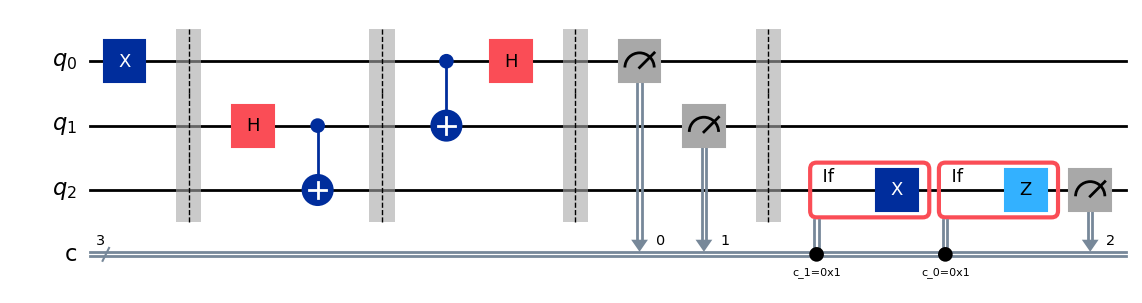

In [9]:
print("Teleportation circuit for |1> state created.")
qc.draw('mpl')

## Step 10: Save Credentials (Run Once)

This block connects to your IBM Quantum account. 

**TO_DO :** You must run the `QiskitRuntimeService.save_account(...)` line *once* in a separate cell to log in. Get your token and CRN from your IBM Quantum dashboard.

In [ ]:
# # --- UNCOMMENT AND RUN THIS CELL ONCE --- 
# # To Run on IBM Quantum Hardware please put your IBM Quantum token below
# from qiskit_ibm_runtime import QiskitRuntimeService

# QiskitRuntimeService.save_account(
#     channel="ibm_quantum_platform", 
#     token="[PASTE_YOUR_API_TOKEN_HERE]",
#     instance="[PASTE_YOUR_INSTANCE_CRN_HERE]", 
#     set_as_default=True
# )

Connecting to IBM Quantum...
Running on real backend: ibm_fez
Running job on real hardware...
Job ID: <bound method BasePrimitiveJob.job_id of <RuntimeJobV2('d4bos8hlag1s73blfjrg', 'sampler')>>

--- Real Device Counts ---
{'110': 267, '101': 231, '111': 226, '100': 255, '000': 15, '001': 15, '011': 9, '010': 6}


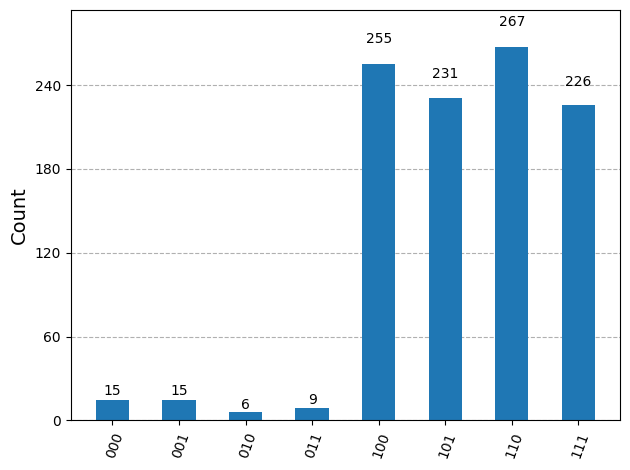

In [ ]:
print("Connecting to IBM Quantum...")

try:
    # 1. Initialize the service (it finds your saved credentials)
    service = QiskitRuntimeService()

    # 2. Find the least-busy REAL quantum computer
    backend_real = service.least_busy(
        operational=True,
        simulator=False,
        min_num_qubits=3 # Ensure it has at least 3 qubits
    )
    print(f"Running on real backend: {backend_real.name}")

    # 3. Transpile the circuit for the specific backend
    transpiled_qc = transpile(qc, backend=backend_real)

    # 4. Initialize the Sampler primitive
    sampler = Sampler(mode=backend_real)

    # 5. Execute the job
    print("Running job on real hardware...")
    job_real = sampler.run([transpiled_qc], shots=1024)
    print(f"Job ID: {job_real.job_id}")

    # 6. Get the results
    result_real = job_real.result()
    
    # 7. Get the counts
    counts_real = result_real[0].data.c.get_counts()
    
    print("\n--- Real Device Counts ---")
    print(counts_real)

    # 8. Plot the final results (The results are 'c2 c1 c0')
    display(plot_histogram(counts_real))

except Exception as e:
    print(f"Could not connect to IBMQ. Running on simulator instead. Error: {e}")
    
    # Fallback to local AerSimulator
    backend_sim = AerSimulator()
    job_sim = backend_sim.run(qc, shots=1024)
    
    result_sim = job_sim.result()
    counts_sim = result_sim.get_counts(qc)
    
    print("\n--- Simulator Counts ---")
    print(counts_sim)
    display(plot_histogram(counts_sim))

## Step 11: Analysis of Results


The results are a 3-bit string: `c2 c1 c0`

### Simulator Result (Ideal)
Since we teleported the `|1>` state, Bob's bit (`c2`) *must* be `1`. Alice's bits (`c1`, `c0`) are random. Therefore, the only possible outcomes are:
- `100` (25%)
- `101` (25%)
- `110` (25%)
- `111` (25%)

You will see **zero counts** for any state starting with `0`.

### Real Hardware Result (Noisy)
The real device has errors. You will see the four correct states (`100`, `101`, `110`, `111`) as the **dominant bars** in the histogram. However, you will also see small, non-zero counts for the 'error' states (e.g., `000`, `001`, `010`, `011`). 

"The histogram clearly shows that the states starting with '1' are the most probable, proving the teleportation protocol successfully transferred the `|1>` state, even in the presence of noise."